## 1. LangChain 中的文档加载

大型语言模型（LLMs）存在数据实时性的问题。即使是像 GPT-4 这样强大的模型也对最近的事件一无所知。

在 LLMs 看来，世界是静止的。它们只知道通过它们的训练数据所呈现的世界。因此我们可以将最新的一些知识文档添加到LLMs中，来补充LLMs模型的知识。

在Langchain 中的通过提示文档加载类（document_loaders）来实现文档的加载，本文将详细介绍如何通过document_loaders实现txt、markdown格式文档的加载



## 2. 案例体验
🔹 本案例需使用 P100 及以上规格运行，请确保运行规格一致，可按照下图切换规格。

![](https://modelarts-labs-bj4-v2.obs.cn-north-4.myhuaweicloud.com/case_zoo/chatglm3/image/1.png)

🔹 点击Run in ModelArts，将会进入到ModelArts CodeLab中，这时需要你登录华为云账号，如果没有账号，则需要注册一个，且要进行实名认证，参考[《ModelArts准备工作_简易版》](https://developer.huaweicloud.com/develop/aigallery/article/detail?id=4ce709d6-eb25-4fa4-b214-e2e5d6b7919c) 即可完成账号注册和实名认证。 登录之后，等待片刻，即可进入到CodeLab的运行环境

🔹 出现 Out Of Memory ，请检查是否为您的参数配置过高导致，修改参数配置，重启kernel或更换更高规格资源进行规避❗❗❗

### 2.1 下载模型和数据

下载nltk_data数据

Natural Language Toolkit (NLTK)是一个广泛使用的Python自然语言处理工具库，由Steven Bird、Edward Loper和Ewan Klein于2001年发起开发。NLTK的目的是为自然语言处理（NLP）提供一个完整的、易于使用的工具集，使研究人员、学生和开发人员能够更加轻松地进行NLP研究和开发。

In [1]:
import os
import moxing as mox

work_dir = '/home/ma-user/work'
obs_path = 'obs://dtse-models/tar-models/nltk_data.tar'
ma_path = os.path.join(work_dir, 'nltk_data.tar')
mox.file.copy(obs_path, ma_path)

mox.file.copy_parallel('obs://modelarts-labs-bj4-v2/case_zoo/langchain-ChatGLM/file/docs','/home/ma-user/work/docs')

INFO:root:Using MoXing-v2.1.0.5d9c87c8-5d9c87c8
INFO:root:Using OBS-Python-SDK-3.20.9.1


进入nltk_data目录，解压数据压缩包

In [2]:
os.chdir(work_dir)
!pwd
!tar -xvf nltk_data.tar

/home/ma-user/work
nltk_data/
nltk_data/misc/
nltk_data/misc/mwa_ppdb.zip
nltk_data/misc/perluniprops.xml
nltk_data/misc/mwa_ppdb.xml
nltk_data/misc/perluniprops.zip
nltk_data/tokenizers/
nltk_data/tokenizers/punkt/
nltk_data/tokenizers/punkt/french.pickle
nltk_data/tokenizers/punkt/polish.pickle
nltk_data/tokenizers/punkt/.DS_Store
nltk_data/tokenizers/punkt/portuguese.pickle
nltk_data/tokenizers/punkt/german.pickle
nltk_data/tokenizers/punkt/swedish.pickle
nltk_data/tokenizers/punkt/malayalam.pickle
nltk_data/tokenizers/punkt/estonian.pickle
nltk_data/tokenizers/punkt/finnish.pickle
nltk_data/tokenizers/punkt/spanish.pickle
nltk_data/tokenizers/punkt/PY3/
nltk_data/tokenizers/punkt/PY3/french.pickle
nltk_data/tokenizers/punkt/PY3/polish.pickle
nltk_data/tokenizers/punkt/PY3/portuguese.pickle
nltk_data/tokenizers/punkt/PY3/german.pickle
nltk_data/tokenizers/punkt/PY3/swedish.pickle
nltk_data/tokenizers/punkt/PY3/malayalam.pickle
nltk_data/tokenizers/punkt/PY3/estonian.pickle
nltk_data

### 2.2 配置环境

本案例依赖Python3.10.10及以上环境，因此我们首先创建虚拟环境：

In [3]:
!/home/ma-user/anaconda3/bin/conda create -n python-3.10.10 python=3.10.10 -y --override-channels --channel https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
!/home/ma-user/anaconda3/envs/python-3.10.10/bin/pip install ipykernel

/home/ma-user/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /home/ma-user/anaconda3/envs/python-3.10.10

  added / updated specs:
    - python=3.10.10


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |             main           3 KB  https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
    _openmp_mutex-5.1          |            1_gnu          21 KB  https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
    bzip2-1.0.8                |       h7b6447c_0          78 KB  https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
    ca-certif

In [4]:
import json
import os

data = {
   "display_name": "python-3.10.10",
   "env": {
      "PATH": "/home/ma-user/anaconda3/envs/python-3.10.10/bin:/home/ma-user/anaconda3/envs/python-3.7.10/bin:/modelarts/authoring/notebook-conda/bin:/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/ma-user/modelarts/ma-cli/bin:/home/ma-user/modelarts/ma-cli/bin:/home/ma-user/anaconda3/envs/PyTorch-1.8/bin"
   },
   "language": "python",
   "argv": [
      "/home/ma-user/anaconda3/envs/python-3.10.10/bin/python",
      "-m",
      "ipykernel",
      "-f",
      "{connection_file}"
   ]
}

if not os.path.exists("/home/ma-user/anaconda3/share/jupyter/kernels/python-3.10.10/"):
    os.mkdir("/home/ma-user/anaconda3/share/jupyter/kernels/python-3.10.10/")

with open('/home/ma-user/anaconda3/share/jupyter/kernels/python-3.10.10/kernel.json', 'w') as f:
    json.dump(data, f, indent=4)

创建完成后，稍等片刻，或刷新页面，点击右上角kernel选择python-3.10.10

![](https://modelarts-labs-bj4-v2.obs.cn-north-4.myhuaweicloud.com/case_zoo/chatglm3/image/2.png)

### 2.3 安装依赖库

In [1]:
!pip install transformers==4.30.2
!pip install sentencepiece==0.1.99
!pip install torch==2.0.1
!pip install markdown==3.4.3
!pip install langchain==0.0.329 -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install nltk==3.8.1 -i https://pypi.tuna.singhua.edu.cn/simple
!pip install unstructured==0.10.24 -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 97.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 67.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 16.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 18.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.5/139.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 kB 9.5 MB/s eta 0:00:00
  

## 3. 加载文档
langchain提供了很多文档加载的类，以便进行不同的文件加载，这些类都通过 langchain.document_loaders 引入。

例如：UnstructuredFileLoader（txt文件读取）、UnstructuredFileLoader（word文件读取）、MarkdownTextSplitter（markdown文件读取）、UnstructuredPDFLoader（PDF文件读取）

本文准备了一个txt和一个md文件进行加载测试，文件默认放在docs目录下，大家也可以直接打开查看。

In [26]:
import os
import nltk
work_dir = '/home/ma-user/work'
docs_path = os.path.join(work_dir, 'docs')
nltk.data.path.append(os.path.join(work_dir, 'nltk_data'))

from langchain.text_splitter import CharacterTextSplitter,MarkdownTextSplitter
from langchain.document_loaders import UnstructuredFileLoader,UnstructuredMarkdownLoader

In [3]:
#加载txt文件
def load_txt_file(txt_file):    
    loader = UnstructuredFileLoader(os.path.join(work_dir, txt_file))
    docs = loader.load()
    print(docs[0].page_content[:100])
    return docs

#加载md文件
def load_md_file(md_file):    
    loader = UnstructuredMarkdownLoader(os.path.join(work_dir, md_file))
    docs = loader.load()
    print(docs[0].page_content[:100])
    return docs

In [4]:
#从docs_path路径加载文件
for doc in os.listdir(docs_path):
    doc_path = f'{docs_path}/{doc}'
    if doc_path.endswith('.txt'):
        load_txt_file(doc_path)
    elif doc_path.endswith('.md'):
        load_md_file(doc_path)

ModelBox是一个适用于端边云场景的AI推理应用开发框架，提供了基于Pipeline的并行执行流程，能帮助AI应用开发者较快的开发出高效，高性能，以及支持软硬协同优化的AI应用。

ModelBo
ModelBox AI应用开发——第一个应用

本文将使用ModelBox开发一个简单的视频应用：读取摄像头，解码出视频帧，再输出原始画面到本地屏幕。读者将了解到ModelBox应用开发的基本流程和应


## 4. 文档分割
对于大语言模型，往往单次传入的token长度是有限的。因此在加载完成后，还需要对文件进行分割，这样才能更准确的被模型所理解。

分割默认有两个关键参数：chunk_size：每个分割段的最大长度；chunk_overlap：相邻两个分割段之间的重叠token数量。这两个参数可以根据实际需要来配置。

In [5]:
#分割txt文件
def load_txt_splitter(txt_file, chunk_size=200, chunk_overlap=20):
    docs = load_txt_file(txt_file)
    text_splitter = CharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    split_docs = text_splitter.split_documents(docs)
    #默认展示分割后第一段内容
    print('split_docs[0]: ', split_docs[0])
    return split_docs

#分割md文件
def load_md_splitter(md_file, chunk_size=200, chunk_overlap=20):
    docs = load_md_file(md_file)
    text_splitter = MarkdownTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    split_docs = text_splitter.split_documents(docs)
    #默认展示分割后第一段内容
    print('split_docs[0]: ', split_docs[0])
    return split_docs

In [6]:
#从docs_path目录读取文件并进行分割
for doc in os.listdir(docs_path):
    doc_path = f'{docs_path}/{doc}'
    if doc_path.endswith('.txt'):
        load_txt_splitter(doc_path)
    elif doc_path.endswith('.md'):
        load_md_splitter(doc_path)

ModelBox是一个适用于端边云场景的AI推理应用开发框架，提供了基于Pipeline的并行执行流程，能帮助AI应用开发者较快的开发出高效，高性能，以及支持软硬协同优化的AI应用。

ModelBo
split_docs[0]:  page_content='ModelBox是一个适用于端边云场景的AI推理应用开发框架，提供了基于Pipeline的并行执行流程，能帮助AI应用开发者较快的开发出高效，高性能，以及支持软硬协同优化的AI应用。\n\nModelBox特点\n\n1. 易于开发\n\nAI推理业务可视化编排开发，功能模块化，丰富组件库；c++，python, Java多语言支持。\n\n2. 易于集成\n\n集成云上对接的组件，云上对接更容易。' metadata={'source': '/home/ma-user/work/docs/modelbox.txt'}
ModelBox AI应用开发——第一个应用

本文将使用ModelBox开发一个简单的视频应用：读取摄像头，解码出视频帧，再输出原始画面到本地屏幕。读者将了解到ModelBox应用开发的基本流程和应
split_docs[0]:  page_content='ModelBox AI应用开发——第一个应用\n\n本文将使用ModelBox开发一个简单的视频应用：读取摄像头，解码出视频帧，再输出原始画面到本地屏幕。读者将了解到ModelBox应用开发的基本流程和应用的基本结构。\n\n1. 传统开发模式' metadata={'source': '/home/ma-user/work/docs/第一个应用.md'}


### 作业2
基于课程4（本案例），实现pdf、jpg格式文档的加载和解析。

In [27]:
%pip install rapidocr_onnxruntime pdf2image pdfminer.six -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import nltk
work_dir = '/home/ma-user/work'
docs_path = os.path.join(work_dir, 'docs')
nltk.data.path.append(os.path.join(work_dir, 'nltk_data'))

from langchain.text_splitter import CharacterTextSplitter,MarkdownTextSplitter
from langchain.document_loaders import UnstructuredFileLoader,UnstructuredMarkdownLoader
from langchain.document_loaders import UnstructuredPDFLoader
from langchain.document_loaders import UnstructuredImageLoader
from rapidocr_onnxruntime import RapidOCR

In [27]:
#加载pdf文件
def load_pdf_file(pdf_file):    
    loader = UnstructuredPDFLoader(os.path.join(work_dir, pdf_file))
    docs = loader.load()
    print('pdf:\n',docs[0].page_content[:100])
    return docs

#加载jpg文件
def load_jpg_file(jpg_file):
    ocr = RapidOCR()
    result,_ = ocr(os.path.join(work_dir,jpg_file))
    docs = ""
    if result:
        ocr_result = [line[1] for line in result]
        docs += "\n".join(ocr_result)
        print('jpg:\n',docs[:100])
    return docs

In [28]:
#从docs_path路径加载文件
for doc in os.listdir(docs_path):
    doc_path = f'{docs_path}/{doc}'
    if doc_path.endswith('.pdf'):
        load_pdf_file(doc_path)
    elif doc_path.endswith('.jpg'):
        load_jpg_file(doc_path)

jpg:
 ModelBox是一个适用于端边云场景的AI推理应用开发框架，提供了基于Pipeline的并行执行流程，能帮助AI应用开发者较快的开发出高效，高性能，
以及支持软硬协同优化的AI应用。
ModelBo
pdf:
 ModelBox 是一个适用于端边云场景的 AI 推理应用开发框架，提供了基于 Pipeline 的并行执 行流程，能帮助 AI 应用开发者较快的开发出高效，高性能，以及支持软硬协同优化的 AI 应 


In [29]:
#分割pdf文件
def load_pdf_splitter(pdf_file, chunk_size=200, chunk_overlap=20):
    docs = load_pdf_file(pdf_file)
    text_splitter = CharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    split_docs = text_splitter.split_documents(docs)
    #默认展示分割后第一段内容
    print('split_docs[0]: ', split_docs[0])
    return split_docs

In [30]:
#分割jpg文件
def load_jpg_splitter(jpg_file, chunk_size=200, chunk_overlap=20):
    docs = load_jpg_file(jpg_file)
    text_splitter = CharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    split_docs = text_splitter.create_documents([docs])
    #默认展示分割后第一段内容
    print('split_docs[0]: ', split_docs[0])
    return split_docs

In [31]:
#从docs_path目录读取文件并进行分割
for doc in os.listdir(docs_path):
    doc_path = f'{docs_path}/{doc}'
    if doc_path.endswith('.pdf'):
        load_pdf_splitter(doc_path)
    elif doc_path.endswith('.jpg'):
        load_jpg_splitter(doc_path)

Created a chunk of size 280, which is longer than the specified 200
Created a chunk of size 602, which is longer than the specified 200


jpg:
 ModelBox是一个适用于端边云场景的AI推理应用开发框架，提供了基于Pipeline的并行执行流程，能帮助AI应用开发者较快的开发出高效，高性能，
以及支持软硬协同优化的AI应用。
ModelBo
split_docs[0]:  page_content='ModelBox是一个适用于端边云场景的AI推理应用开发框架，提供了基于Pipeline的并行执行流程，能帮助AI应用开发者较快的开发出高效，高性能，\n以及支持软硬协同优化的AI应用。\nModelBox特点\n1．易于开发\nAI推理业务可视化编排开发，功能模块化，丰富组件库；c++，python，Java多语言支持。\n2．易于集成\n集成云上对接的组件，云上对接更容易。\n3．高性能，高可靠\npipeline并发运行，数据计算智能调度，资源管理调度精细化，业务运行更高效。\n4．软硬件异构\nCPU，GPU，NPU多异构硬件支持，资源利用更便捷高效。\n5．全场景\n视频，语音，文本，NLP全场景，专为服务化定制，云上集成更容易，端边云数据无缝交换。\n6．易于维护\n服务运行状态可视化，应用，组件性能实时监控，优化更容易。\nModelBox解决的问题\n目前AI应用开发时，训练完成模型后，需要将多个模型和应用逻辑串联在一起组成AI应用，并上线发布成为服务或应用。在整个过程中，需要面临复杂\n的应用编程问题：\n1．需要开发AI应用的周边功能：比如AI应用编译工程，应用初始化，配置管理接口，日志管理口，应用故障监控等功能。\n2．需要开发AI常见的前后处理：音视频加解码，图像转换处理，推理前处理，后处理YOLO等开发。\n3．需要开发和云服务对接的周边功能：比如HTTP服务开发，云存储，大数据服务，视频采集服务对接开发。\n4．需要开发出高性能的推理应用：需要基于多线程，内存池化，显存池化，多GPU加速卡，模型batch批处理，调用硬件卡的API等手段开发应用。\n5．需要开发验证docker镜像：需要开发docker镜像，集成必要的ffmpeg，opencv软件，cuDA，MindSpore，TensorFlow等软件，并做集成测试验\n证。\n6．多种AI业务，需要共享代码，降低维护工作：需要复用不同组件的代码，包括AI前后处理代码，AI应用管理代码，底层内存，线程管理代码等。\n

In [15]:
%pip install pypdfium2 matplotlib -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 88.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 75.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 13.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
#将PDF的每一页作为图像列表返回
#PDF以图像格式可视化

import pypdfium2 as pdfium 
import matplotlib.pyplot as plt
import os
import nltk
from io import BytesIO
from PIL import Image
work_dir = '/home/ma-user/work'
docs_path = os.path.join(work_dir, 'docs')
nltk.data.path.append(os.path.join(work_dir, 'nltk_data'))

def convert_pdf_to_images(file_path, scale=300/72):
   
   pdf_file = pdfium.PdfDocument(file_path)
   
   page_indices = [i for i in range(len(pdf_file))]
   
   renderer = pdf_file.render(
       pdfium.PdfBitmap.to_pil,
       page_indices = page_indices, 
       scale = scale,
   )
   
   final_images = [] 
   
   for i, image in zip(page_indices, renderer):
       
       image_byte_array = BytesIO()
       image.save(image_byte_array, format='jpeg', optimize=True)
       image_byte_array = image_byte_array.getvalue()
       final_images.append(dict({i:image_byte_array}))
   
   return final_images


In [18]:

def display_images(list_dict_final_images):
   
   all_images = [list(data.values())[0] for data in list_dict_final_images]
   
   for index, image_bytes in enumerate(all_images):
       
       image = Image.open(BytesIO(image_bytes))
       figure = plt.figure(figsize = (image.width / 100, image.height / 100))
       
       plt.title(f"----- Page Number {index+1} -----")
       plt.imshow(image)
       plt.axis("off")
       plt.show()


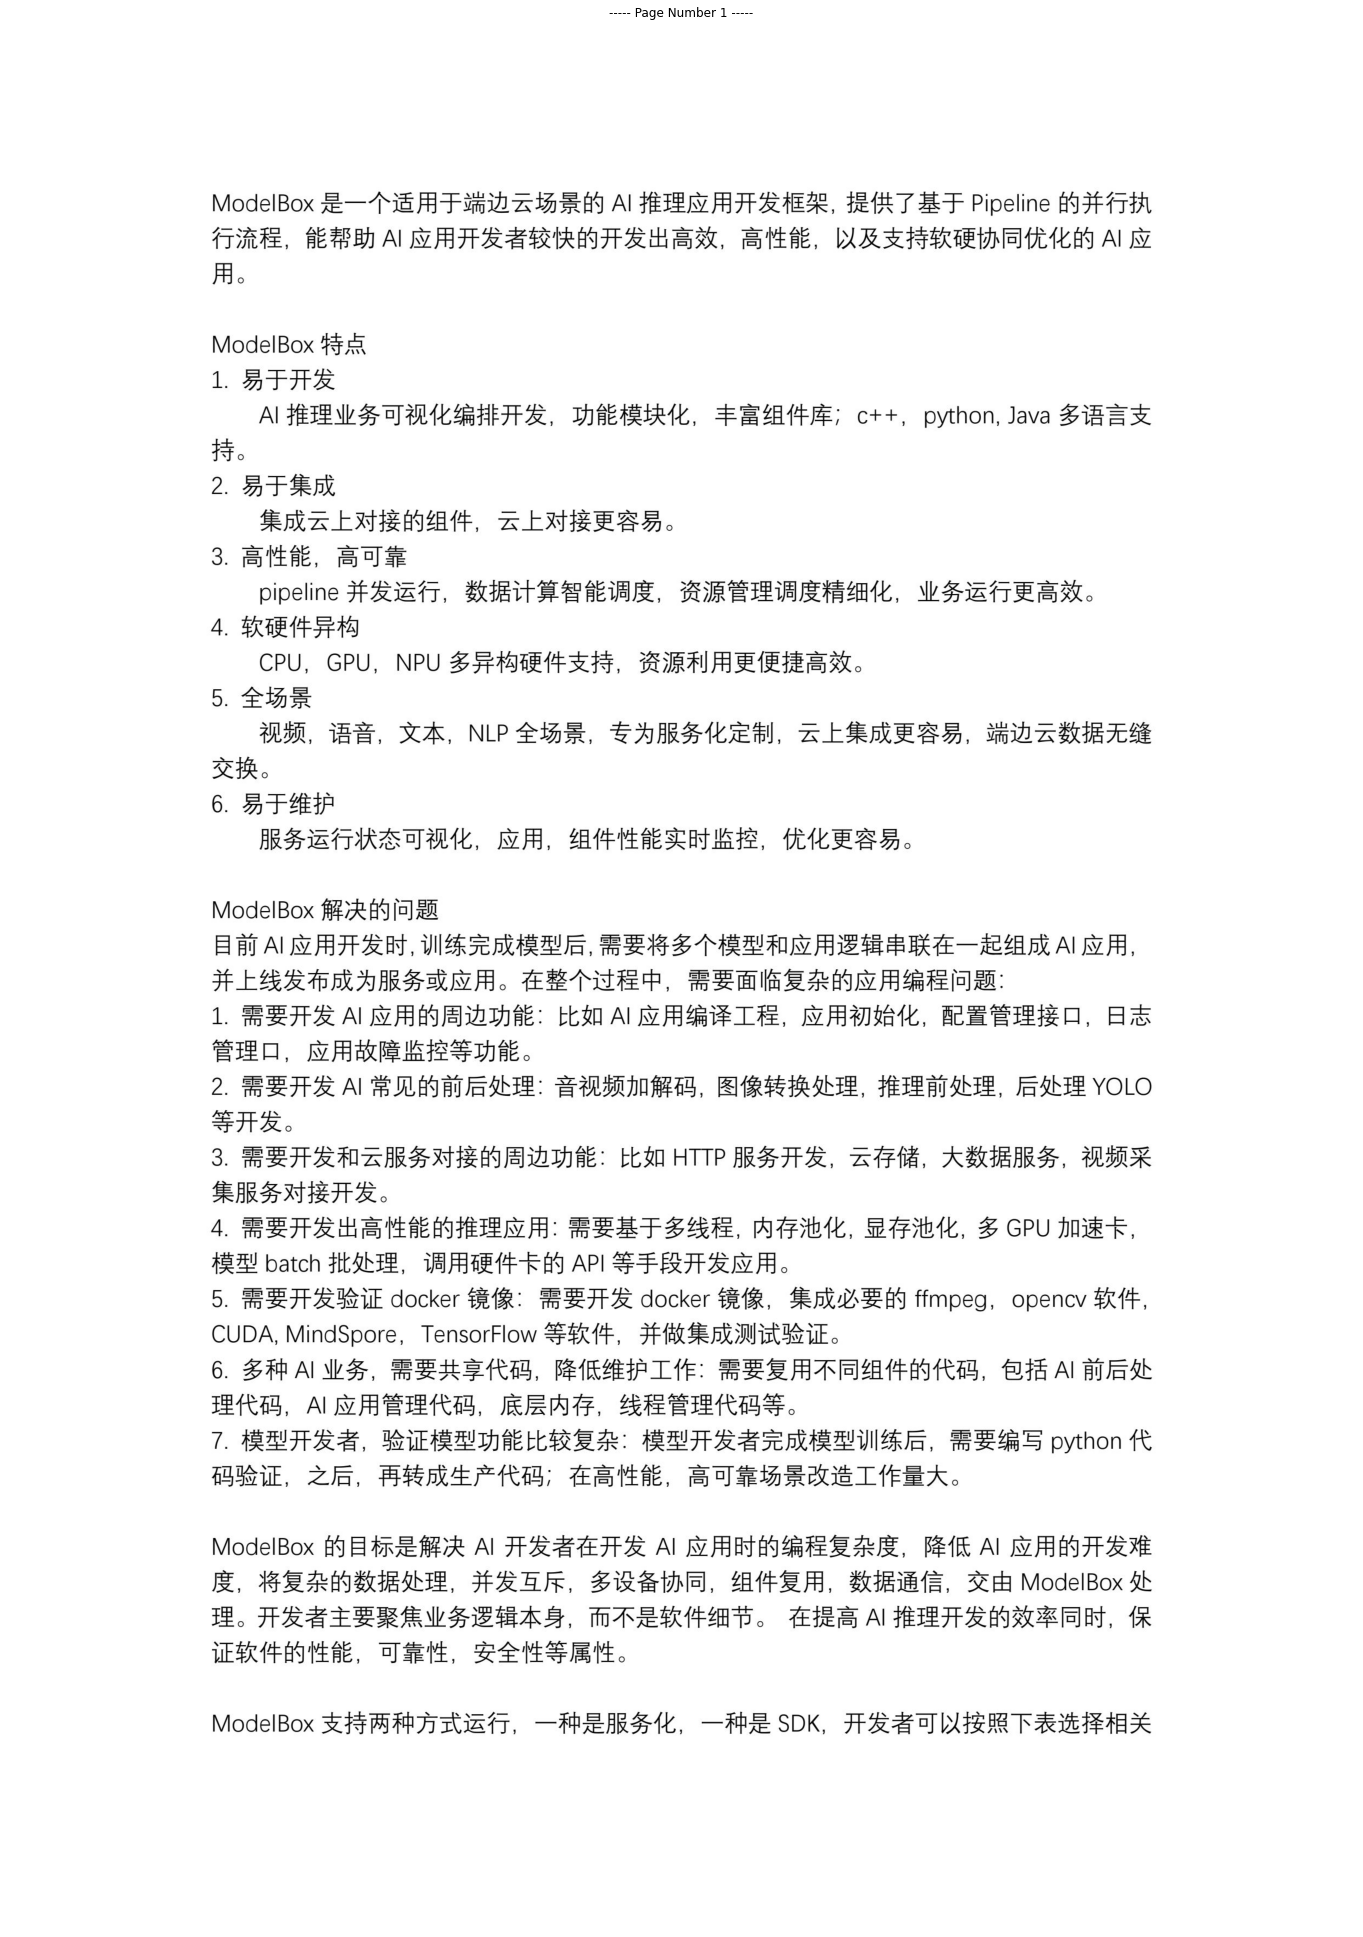

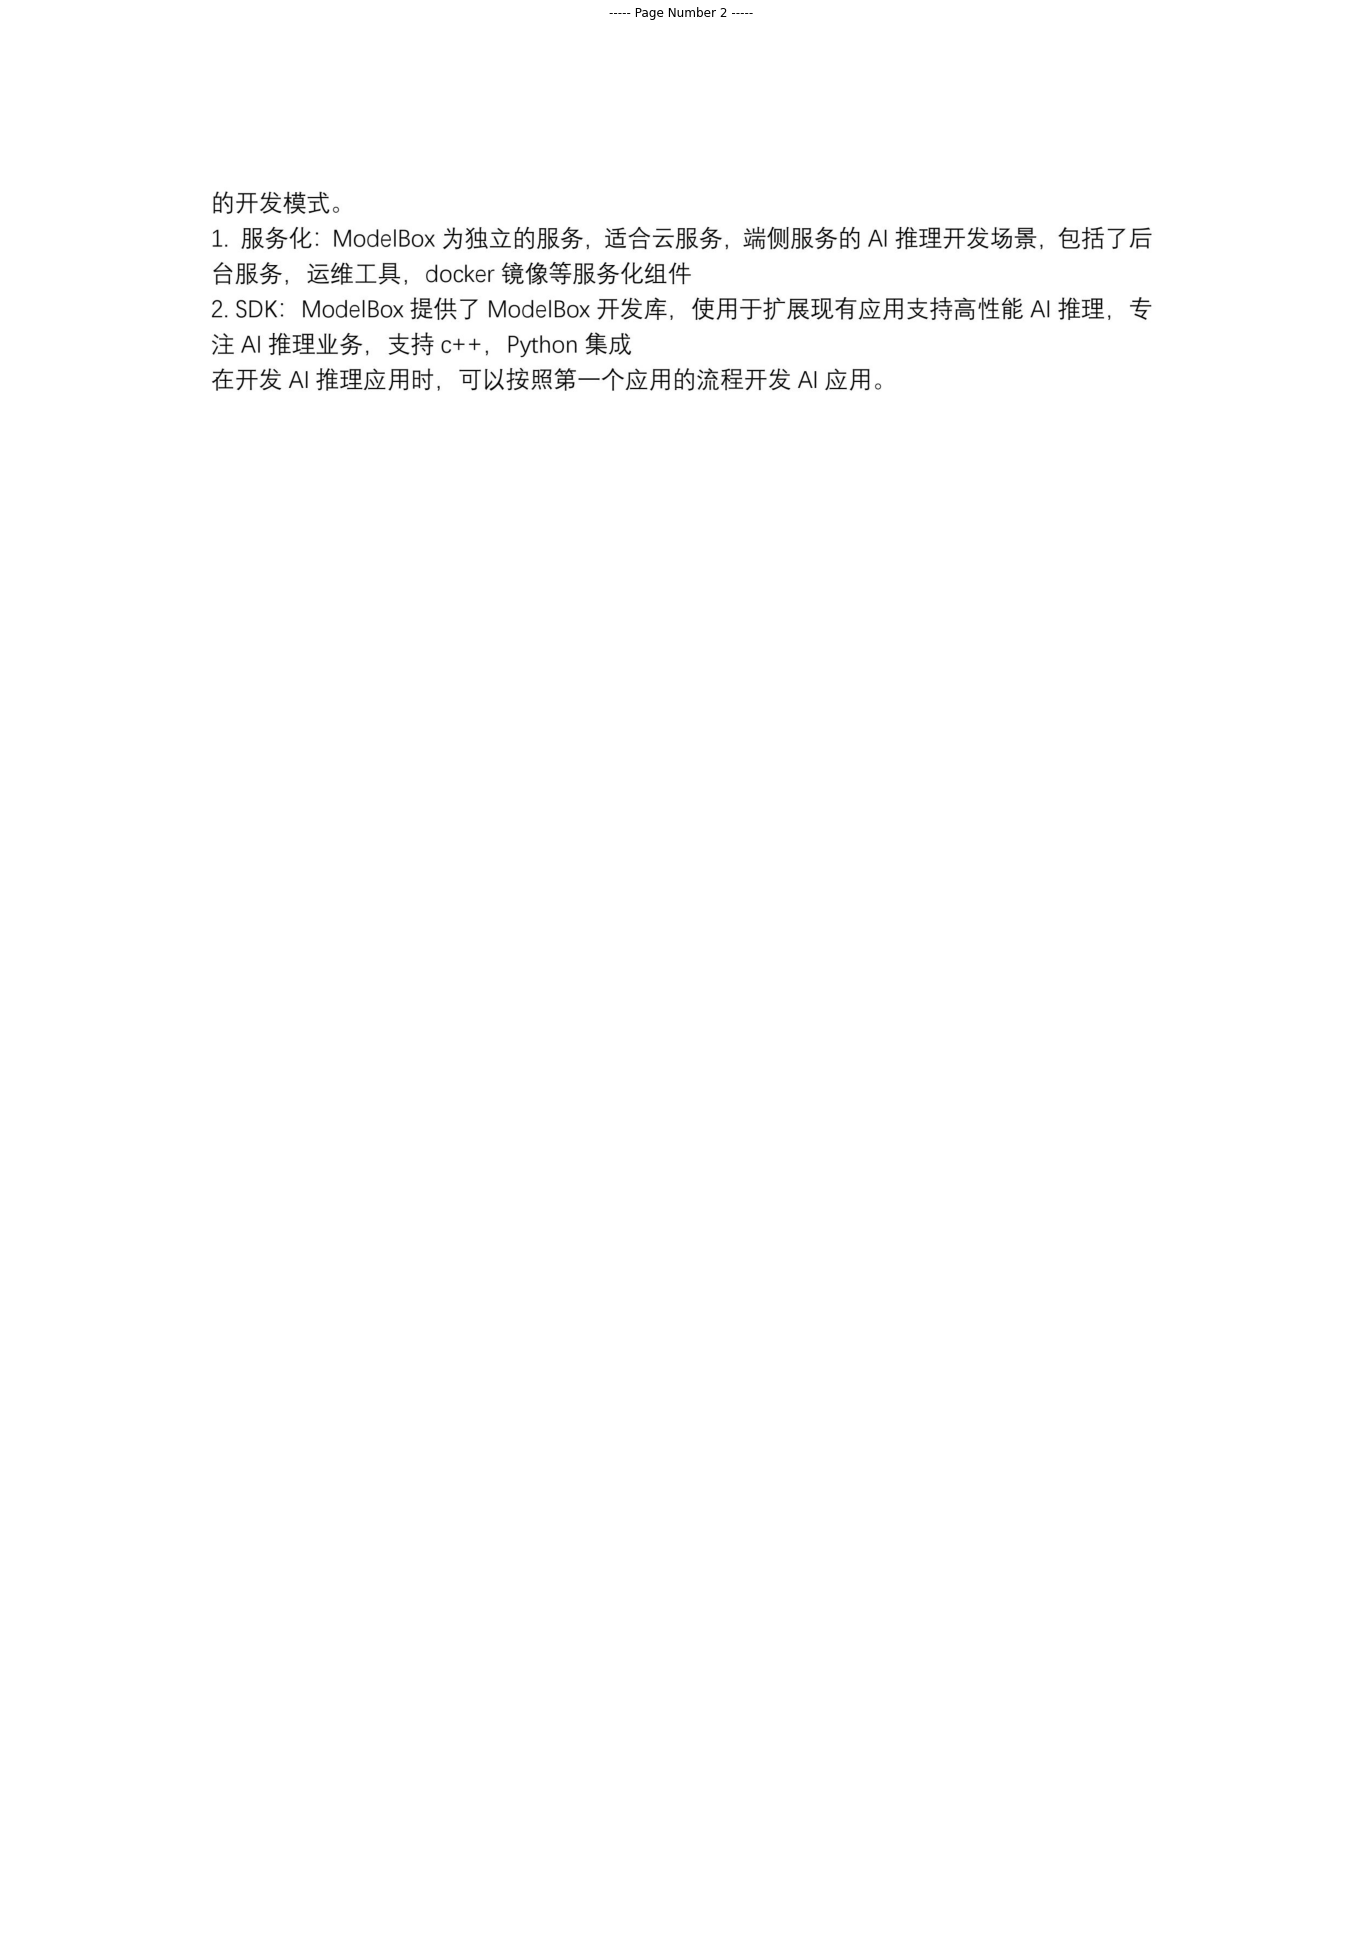

In [19]:
for doc in os.listdir(docs_path):
    doc_path = f'{docs_path}/{doc}'
    if doc_path.endswith('.pdf'):
        convert_pdf_to_images = convert_pdf_to_images(doc_path)
        display_images(convert_pdf_to_images)